## Assignment 1, Computer Vision UU

#### Ioannidis Theodoros , Ioannidis Christos 

##### Aknowledgements:

https://www.geeksforgeeks.org/displaying-the-coordinates-of-the-points-clicked-on-the-image-using-python-opencv/ 

https://docs.opencv.org/4.x/dd/d43/tutorial_py_video_display.html

https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html


In [1]:
import cv2 as cv
import numpy as np
import os
import math

In [2]:
 
def click_corners(img, objpoints, imgpoints, objp, window, n_rows=9, n_cols=6):
    """
    get 4 corners from user clicks (in order) and use linear interpolation to get the 
    other inner points.
    """

    order = ['TL', 'BL', 'TR', 'BR']
    box_corners = []
    
    # function to handle clicks on the image  
    def click_event(event, x, y, flags, param): 
        
        box_corners, img, window = param
        
        # check for left mouse clicks 
        if event == cv.EVENT_LBUTTONDOWN and len(box_corners) < 4: 
            
            box_corners.append((x, y))
    
            # display clicked points
            # on the image window 
            font = cv.FONT_HERSHEY_SIMPLEX 
            cv.putText(img, order[len(box_corners)-1], (x,y), font, 
                        1, (255, 0, 0), 2) 
            cv.imshow(window, img)
 
    cv.namedWindow(window, cv.WINDOW_NORMAL)
    cv.imshow(window, img) 
    cv.setMouseCallback(window, click_event, [box_corners, img, window]) 
    # wait for a key to be pressed to exit 
    print("click on the 4 corners, then press any key.")
    cv.waitKey(0) 

    tl, bl, tr, br = np.array(box_corners, dtype=np.float32)

    # get first and last columns of points with linear interpolation
    first_col = np.linspace(tl, bl, n_rows) 
    last_col = np.linspace(tr, br, n_rows) 

    # get rest corner points by linearly interpolating the two columns
    all_points = np.vstack([
        np.linspace(first_col[i], last_col[i], n_cols) for i in range(n_rows)
    ])
    corners = all_points.reshape(-1, 1, 2)

    objpoints.append(objp)
    imgpoints.append(corners)

    cv.destroyWindow(window)
    cv.drawChessboardCorners(img, (n_rows, n_cols), corners, True)
    cv.imshow("Interpolated Chessboard Corners", img)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [3]:
def find_auto(img, gray, objpoints, imgpoints, objp, window, n_rows=9, n_cols=6):
    """
    used to find the corner points and fill objpoints, imgpoints lists
    img, gray: original and grayscale image
    """

    # choice task - denoising
    gray = cv.fastNlMeansDenoising(gray, None, h=10)

    # detect chess board corners
    ret, corners = cv.findChessboardCorners(gray, (n_rows,n_cols), None)

    if ret:        
        # improve quality of automatically found corners    
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

        objpoints.append(objp)
        imgpoints.append(corners)
        
        # display the corners on image
        cv.drawChessboardCorners(img, (n_rows,n_cols), corners, True)
        cv.imshow(window, img)
        cv.waitKey(0)
        cv.destroyWindow(window)
    else:
        # if corners are not found, switch to manual mode
        click_corners(img, objpoints, imgpoints, objp, window, n_rows, n_cols)


In [4]:
def compute_reprojection_errors(objpoints, imgpoints, rvecs, tvecs, mtx, dist):
    """
    after calibrating the camera we reproject the points of the training images based on rvecs, tvecx and the matrix 
    and compute the distance to the actual points [reprojection error]
    input: objpoints, imgpoints, rvecs, tvecs, mtx, dist (defined before)
    output: list the reprojection errors
    """
    errors = []
    for i in range(len(objpoints)):
        # Project the 3D points back to the image
        imgpoints_proj, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        # Compute error between detected points and projected points
        error = cv.norm(imgpoints[i], imgpoints_proj, cv.NORM_L2) / len(imgpoints_proj)
        errors.append(error)
    return errors


In [5]:
def run(data='./data' , n_rows=9, n_cols=6, mode=1):
    """
    offline phase 
    mode defines the run setting (1,2,3)
    (n_rows, n_cols): the number of inner points to look for
    in our case and pattern we have (9,6)
    """

    images= os.listdir('./data') # mode 1 (using all images)

    if mode==2:
        images = images[-10:] 
    if mode==3:
        images = images[-5:] 
       
    objp = np.zeros((n_rows*n_cols,3), np.float32)
    objp[:,:2] = np.mgrid[0:n_rows,0:n_cols].T.reshape(-1,2)
    objp= objp*16.5  # we measured the side of each square to be 16,5mm  

    # Lists to store object and image points from all images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    
    for fname in images:
        
        img = cv.imread(f'./data/{fname}')
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # we convert to grayscale before passing to 'findChessboardCorners'

        window = f'image_{fname}'
        # find chess board corners either automatically or manually
        find_auto(img, gray, objpoints, imgpoints, objp, window, n_rows=n_rows, n_cols=n_cols)

    cv.destroyAllWindows()    
    # caliibrate camera and return results
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return ret, mtx, dist, rvecs, tvecs

In [6]:
def run_bonus(data='./data' , n_rows=9, n_cols=6, mode=1):
    """
    offline phase 
    mode defines the run setting (1,2,3)
    (n_rows, n_cols): the number of inner points to look for
    in our case and pattern we have (9,6)
    we add the iterative detection and rejection of images and recalibration of the camera.
    we compute it with a threshold of 2.5 (trial and error) and with a max number of iterations as 5
    """

    images= os.listdir('./data') # mode 1 (using all images)

    if mode==2:
        images = images[-10:] 
    if mode==3:
        images = images[-5:] 
    
    objp = np.zeros((n_rows*n_cols,3), np.float32)
    objp[:,:2] = np.mgrid[0:n_rows,0:n_cols].T.reshape(-1,2)
    objp= objp*16.5  # we measured the side of each square to be 16,5mm  

    # Lists to store object and image points from all images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    
    for fname in images:
        
        img = cv.imread(f'./data/{fname}')
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # we convert to grayscale before passing to 'findChessboardCorners'

        window = f'image_{fname}'
        # find chess board corners either automatically or manually
        find_auto(img, gray, objpoints, imgpoints, objp, window, n_rows=n_rows, n_cols=n_cols)

    cv.destroyAllWindows()    

    iteration = 0
    while iteration < 5:

        #first calibration
        ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        #we compute the reprojection errors based on the function above
        errors = compute_reprojection_errors(objpoints, imgpoints, rvecs, tvecs, mtx, dist)
        #we find the mean error
        mean_error = np.mean(errors)

        print(f"run {iteration+1}: mean reprojection error = {mean_error}")

        #keep track only the images with error higher than 2.5 which was an indicative measure derived through trial and error
        new_objpoints = []
        new_imgpoints = []
        for i, err in enumerate(errors):
            if err < 2.5:
                new_objpoints.append(objpoints[i])
                new_imgpoints.append(imgpoints[i])
            else:
                print(f"removing image {i+1} with error {err}")
        
        # break if no rejected images
        if len(new_objpoints) == len(objpoints):
            break
        
        objpoints = new_objpoints
        imgpoints = new_imgpoints
        iteration += 1
    
    # final calibration (in case we rejected in all iterations)
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return ret, mtx, dist, rvecs, tvecs

In [7]:
def draw_cube(img, imgpts):
    """
    function that defines and draws the cube by connecting the points given by imgpts with edges (with cv.line)
    edges defines which corners/vertices of the cube should be connected
    input:
    img-np array
    imgpts-the vertices of the cube
    output:
    img-np array with the cube drawn on the input image
    """
    imgpts = np.int32(imgpts).reshape(-1,2)

    edges = [
        (0,1), (1,2), (2,3), (3,0),  # bottom face
        (4,5), (5,6), (6,7), (7,4),  # bop face
        (0,4), (1,5), (2,6), (3,7)   # bertical edges
    ]

    for edge in edges:
        i, j = edge
        img = cv.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (0, 255, 255), 3)


    return img

In [8]:
def fill_top_face_with_hsv(img, cube_3d_points, rvec, tvec, mtx, dist):
    """
    color the top face of the cube according to the assignment description:
    - distance from camera
    - orientation realevant to camera
    - position realevant to camera 
    input:
    img : np array the image with the cube on it
    cube_3d_points : np array
    rvec: np array rotation vector
    tvec : np array translation vector, the cubes position relative to the camera
    mtx : np array camera's intrinisc parameters, camera matriz
    dist : np array distortion coefficients
    output: 
    img: np array the image with the top face of the cube colored
    """


    top_face_idxs = [4,5,6,7]
    top_face_3d = cube_3d_points[top_face_idxs] 

    imgpts_top, _ = cv.projectPoints(top_face_3d, rvec, tvec, mtx, dist) # we have to get the coordinates of the top face points
    imgpts_top = np.int32(imgpts_top).reshape(-1,2)   

    # center of the top face
    center_3d_obj = np.mean(top_face_3d, axis=0)  

    # rotation matrix from rvec to get the center in camera coordinates
    R, _ = cv.Rodrigues(rvec)  # we convert rvec that is vector to rotation matrix
    center_cam = R.dot(center_3d_obj) + tvec.ravel()  

    dist_to_cam = np.linalg.norm(center_cam) # for distance we take into account all axes, x y and z

    # compute normal vector of the top face
    normal_obj = np.array([0,0,1], dtype=np.float32)
    normal_cam = R.dot(normal_obj)

    #now we find its angle with the camera view axis
    camera_axis = np.array([0,0,1], dtype=np.float32)
    dotval = np.dot(normal_cam, camera_axis)
    norms  = np.linalg.norm(normal_cam)*np.linalg.norm(camera_axis) 
    cos_angle = np.clip(dotval / (norms + 1e-9), -1.0, 1.0)
    angle_deg = math.degrees(math.acos(cos_angle))

    # hue: position in camera space in x
    x_cam = center_cam[0]
    hue_min, hue_max = 0, 180
    x_min,  x_max = -500, 500  
    if x_cam <= x_min:
        H = hue_min
    elif x_cam >= x_max:
        H = hue_max
    else:
        H = hue_min + (hue_max - hue_min) * (x_cam - x_min)/(x_max - x_min) # linear interpolation

    # saturation : less saturation if face is tilted too much
    if angle_deg >= 45.0:
        S = 0
    else:
        S = 255.0*(1.0 - angle_deg/45.0)
    S = max(0, min(255, S))

    # closer = brighter, farther = darker, max = 4000 and we normalize to 0-255
    max_dist = 4000
    V = 255.0*(1.0 - dist_to_cam/max_dist)
    V = max(0, min(255, V))

    hsv_color = np.uint8([[[H, S, V]]])  
    bgr_color = cv.cvtColor(hsv_color, cv.COLOR_HSV2BGR)[0][0]  

    bgr_tuple = tuple(map(int, bgr_color))  
    cv.fillConvexPoly(img, imgpts_top, bgr_tuple)

    return img

In [9]:
def drawAxesCube(img, mtx, dist):
    """
    detects crossboard and estimates its pose, then plots on the plane of its surface the 3D coordinate system
    and also draws a cube calculated in draw_cube() with its top face colored according to fill_top_face_with_hsv()
    
    input
    img : np array chessboard image
    mtx : np array camera matrix, calculated after calibration
    dist : np array distortion coefficients calculated after calibration
    
    Returns:
    --------
    np array: image with the drawn axes and cube
    """

    #grayscale and find corners automatically (if it doesnt find it, it returns the image) 
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, corners = cv.findChessboardCorners(gray, (9,6), None)
    if not ret:
        return img

    #we refine the corners
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    corners = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

    objp = np.zeros((9*6, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    objp = objp * 16.5 

    #estimate rotation vector and translation vector by solving based on the camera calibration 
    _, rvec, tvec = cv.solvePnP(objp, corners, mtx, dist)

    square = 16.5
    cube_side = 2 * 16.5  # cube side size = 2 board squares

    # coordinate system
    axis = np.float32([[0,0,0],
                        [5*square,0,0],
                        [0,5*square,0],
                        [0,0,-5*square]])
                        
    # cube (it is "-" in z because of opencv default settings)
    cube = np.float32([
        [0,0,0],
        [cube_side, 0, 0],
        [cube_side, cube_side, 0],
        [0, cube_side, 0],
        [0, 0, -cube_side],
        [cube_side, 0, -cube_side],
        [cube_side, cube_side, -cube_side],
        [0, cube_side, -cube_side]
    ])

    # project the axis points and cube points to the 2D image and then convert to pixel coordinates
    imgpts_axis, _ = cv.projectPoints(axis, rvec, tvec, mtx, dist)
    imgpts_cube, _ = cv.projectPoints(cube, rvec, tvec, mtx, dist)
    origin = tuple(map(int, imgpts_axis[0].ravel()))
    pt_x   = tuple(map(int, imgpts_axis[1].ravel()))
    pt_y   = tuple(map(int, imgpts_axis[2].ravel()))
    pt_z   = tuple(map(int, imgpts_axis[3].ravel()))
    cv.circle(img, origin, 5, (0, 255, 255), -1)

    cv.arrowedLine(img, origin, pt_x, (0,0,255), 3, tipLength=0.1)  # X
    cv.arrowedLine(img, origin, pt_y, (0,255,0), 3, tipLength=0.1)  # Y
    cv.arrowedLine(img, origin, pt_z, (255,0,0), 3, tipLength=0.1)  # Z
    cv.putText(img, 'X', pt_x, cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv.LINE_AA)
    cv.putText(img, 'Y', pt_y, cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv.LINE_AA)
    cv.putText(img, 'Z', pt_z, cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv.LINE_AA)

    # draw cube on image
    img = draw_cube(img, imgpts_cube)
    img = fill_top_face_with_hsv(img, cube, rvec, tvec, mtx, dist)

    return img


In [25]:
def online(setting='t', mtx=None, dist=None):
    """
    setting t -> perform online phase on test image
    setting c -> perform online phase on frames captured by webcam
    requires camera matrix and distortion coeffs from camera calibration
    """

    if setting=='c':
        # use webcam
        cam = cv.VideoCapture(0)
        record = cv.VideoWriter('webcamtask.mp4', -1, 20.0, (640,480))
        
        while True:
            # get frame
            ret, frame = cam.read()
            
            if not ret:
                print("no frame")
                break
            
            # draw axes and cube if chessboard pattern is found 
            frame = drawAxesCube(frame, mtx=mtx, dist=dist)
            frame = cv.flip(frame,1)
            record.write(frame)

            cv.imshow("Webcam", frame)
            
            # q to exit and close webcam
            if cv.waitKey(1) & 0xFF == ord('q'):
                cam.release()
                record.release()
                cv.destroyAllWindows()
                break

    elif setting=='t':
        # read test image
        test_img = './test.jpg'
        img = cv.imread(test_img)
        # draw cube and axes using camera intrinsics
        image = drawAxesCube(img, mtx=mtx, dist=dist)
        cv.imshow("Webcam", image)
        cv.waitKey(0)
        cv.destroyAllWindows()


In [21]:
import matplotlib.pyplot as plt

def plot_camera_positions(tvecs):
    """
    Plots the estimated camera positions in 3D space relative to the chessboard
    input: 
    tvec: np array of the translation vectors
    """

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect((1,1,1))

    # X, Y, Z coordinates from tvecs
    tvecs = np.array(tvecs).squeeze()  

    # plot camera positions
    colors = np.linspace(0, 1, len(tvecs))
    ax.scatter(tvecs[:, 0], tvecs[:, 1], tvecs[:, 2], c=colors, cmap='viridis', marker='o', s=40, alpha=0.8, label="Camera Positions")

    # label axes
    ax.set_xlabel('X Position (mm)')
    ax.set_ylabel('Y Position (mm)')
    ax.set_zlabel('Z Position (mm)')
    ax.set_title('Camera Locations Relative to Chessboard')

    # mark the chessboard origin
    ax.scatter(0, 0, 0, c='red', marker='x', s=100, label="Chessboard Origin")

    ax.legend()

    ax.view_init(elev=20, azim=-60)
    plt.tight_layout()
    plt.show()


Run 1
click on the 4 corners, then press any key.
click on the 4 corners, then press any key.
click on the 4 corners, then press any key.
click on the 4 corners, then press any key.
Ret 17.253832463429056, mtx [[3.31534123e+03 0.00000000e+00 6.64395345e+02]
 [0.00000000e+00 4.98676818e+03 3.53581526e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]], dist [[ 3.60155428e-01 -1.06298922e+01  6.54956074e-02  4.42194935e-02
   1.94475434e+04]], rvecs (array([[ 0.38106636],
       [ 1.368221  ],
       [-0.23069309]]), array([[-0.65640312],
       [-0.81323286],
       [-1.52653814]]), array([[ 1.38912016],
       [ 0.97532218],
       [-1.24653829]]), array([[ 0.3744314 ],
       [ 1.36796924],
       [-0.22557035]]), array([[-1.41720816],
       [-0.95564945],
       [-1.49394817]]), array([[-0.69726272],
       [-0.65642387],
       [-1.47769131]]), array([[-0.65590334],
       [-0.72507623],
       [-1.59384824]]), array([[-0.6199857 ],
       [-0.77607475],
       [-1.66261466]]), a

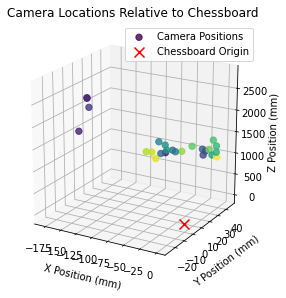

Run 2
Ret 0.1943074913434145, mtx [[955.04093848   0.         668.89430369]
 [  0.         954.35454311 358.7408456 ]
 [  0.           0.           1.        ]], dist [[ 0.04530742 -0.38003558 -0.0020512  -0.00083052  0.66978238]], rvecs (array([[-0.0936535 ],
       [-0.13345167],
       [-1.73634357]]), array([[-0.09935736],
       [-0.11382166],
       [-1.74900609]]), array([[ 0.19336213],
       [-0.06384053],
       [-1.4817838 ]]), array([[-0.2789553 ],
       [-0.18159497],
       [-1.69400603]]), array([[-0.16142024],
       [-0.05459069],
       [-1.88087493]]), array([[-0.15253827],
       [-0.00367889],
       [-1.39435319]]), array([[-0.45229059],
       [-0.68695759],
       [-1.53353765]]), array([[-0.53129711],
       [-0.5637232 ],
       [-1.4205415 ]]), array([[-0.4062419 ],
       [-0.61765146],
       [-1.24939613]]), array([[-0.3943378 ],
       [-0.27913206],
       [-2.42142486]])), tvecs (array([[ -6.97610297],
       [ 60.95970968],
       [311.80917208]]), ar

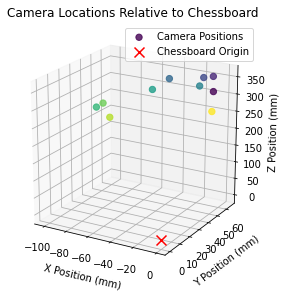

Run 3
Ret 0.15581320792041245, mtx [[955.99561561   0.         662.75954524]
 [  0.         954.27375748 355.46163104]
 [  0.           0.           1.        ]], dist [[ 0.03730591 -0.3899852  -0.00203883 -0.00438771  0.73327994]], rvecs (array([[-0.15811706],
       [ 0.00438653],
       [-1.39397003]]), array([[-0.45727635],
       [-0.68323924],
       [-1.53100523]]), array([[-0.53633983],
       [-0.55973217],
       [-1.41811867]]), array([[-0.41043181],
       [-0.61407557],
       [-1.24705346]]), array([[-0.40430043],
       [-0.27573527],
       [-2.41982198]])), tvecs (array([[-54.44771859],
       [ 55.77679054],
       [300.42417655]]), array([[-100.32585695],
       [  48.12516534],
       [ 234.59748007]]), array([[-92.64234995],
       [ 46.921979  ],
       [252.76036778]]), array([[-81.09262158],
       [ 41.12294339],
       [226.48506108]]), array([[ -5.19601416],
       [ 60.47330972],
       [256.43836189]]))


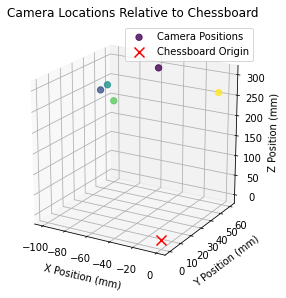

In [12]:
for i in range(1,4):
    print(f"Run {i}")
    bonus = False # set to true to run with iterative rejection of low quality corner detection and recalibration 
    if bonus:
        ret, mtx, dist, rvecs, tvecs = run_bonus(n_rows=9, n_cols=6, mode=i)
    else: 
        ret, mtx, dist, rvecs, tvecs = run(n_rows=9, n_cols=6, mode=i) 
    print(f"Ret {ret}, mtx {mtx}, dist {dist}, rvecs {rvecs}, tvecs {tvecs}")
    plot_camera_positions(tvecs)
    online(setting='t', mtx=mtx, dist=dist)

In [26]:
# Coice task 1 (real-time performance with webcam)
ret, mtx, dist, rvecs, tvecs = run(n_rows=9, n_cols=6, mode=3)
online(setting='c', mtx=mtx, dist=dist)
# press q to close window